In [104]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.cluster import KMeans  

def threshold(electrodeData):
    return  5* np.std(electrodeData)

def smooth(X_array):     #moving average with window size=48
     y_array=[]
     N=48
     for n in range (47,len(X_array)):
        i=1
        sum=0
        while(i<=N):
            sum+=X_array[n-(N-i)]
            i+=1
       
        y_array.append(sum/N+0.0)
     return np.array(y_array) 
def  separate_electrodes(data):
    electrode1=np.array(data[:,0])
    electrode2=np.array(data[:,1])
    return electrode1,electrode2
def get_spike_peaks(electrode,all_peak_indices_elec,spike_width=48):
    peak_indices=[]  #peak_indices has only values of spikes' peaks
    peak_values=[]
    j=0
    max_length=len(all_peak_indices_elec)
    while(j<max_length):
        spike_start_index = all_peak_indices_elec[j][0]
        spike_end_index=spike_start_index+spike_width  #spike width= 48 Ts
        same_spike_peaks=[]
        max_index= all_peak_indices_elec[j][0]
        while(j< max_length and all_peak_indices_elec[j][0]<spike_end_index):  #values higher than threshold in the same spike
            if(electrode[all_peak_indices_elec[j][0]] > electrode[max_index]):
                max_index=all_peak_indices_elec[j][0]
            j=j+1       
        #here we reached a new spike, so save the peak value of the pre spike and start searching for the peak of the next one
        peak_indices.append(max_index)
        peak_values.append(electrode[max_index])
                            
    return peak_indices,peak_values

def get_spike_Details(electrode,peaks_elec):
    electrode_spike_values=np.empty([len(peaks_elec), 48])
    electrode_timestamps=[]
    for i in range(len(peaks_elec)):
        spike_start=peaks_elec[i]-24
        spike_end = peaks_elec[i]+24
        electrode_timestamps.append(peaks_elec[i])  #time(Ts) of spike's peak value
        count=0
        for j in range(spike_start,spike_end):
            if(j>=len(electrode)):continue
            electrode_spike_values[i][count]=electrode[j]
            count=count+1
           
    return electrode_spike_values,electrode_timestamps




In [3]:
data = np.loadtxt("Data.txt", delimiter="\t")
rectifiedData=np.absolute(data)
print("smoothing data")
#smoothed_data=smooth(rectifiedData)
#print("next")

smoothing data


In [105]:
Ts=1/24414.0
electrode1,electrode2=separate_electrodes(data)
threshold_elec1=threshold(electrode1[0:500])
threshold_elec2=threshold(electrode2[0:500])
electrode1,electrode2=separate_electrodes(rectifiedData)

all_peak_indices_elec1 = np.argwhere(electrode1 > threshold_elec1) #it holds any peak value higher than the threshold  
all_peak_indices_elec2 = np.argwhere(electrode2 > threshold_elec2)

peaks_elec1,peak_values_elec1=get_spike_peaks(electrode1,all_peak_indices_elec1) #each value represents the peak of a spike
peaks_elec2,peak_values_elec2=get_spike_peaks(electrode2,all_peak_indices_elec2)

electrode1,electrode2=separate_electrodes(data)

electrode1_spike_values,electrode1_timestamps=get_spike_Details(electrode1,peaks_elec1)
electrode2_spike_values,electrode2_timestamps=get_spike_Details(electrode2,peaks_elec2)


print("done")
print(threshold_elec1,threshold_elec2)
print(len(peaks_elec1),len(peaks_elec2))
print(len(electrode1_timestamps))
len(electrode1)
print(len(peaks_elec1))
print(len(peak_values_elec1))
print(electrode1_spike_values.shape)
print(electrode2_spike_values.shape)

done
4.316008541798502e-05 3.7981326109211766e-05
2472 586
2472
2472
2472
(2472, 48)
(586, 48)


In [106]:
#using PCA to reduce spikes' dimension to 2D
pca_elec1 = decomposition.PCA(n_components=2)
electrode1_decomposed_spike_values= pca_elec1.fit_transform(electrode1_spike_values)

pca_elec2 = decomposition.PCA(n_components=2)
electrode2_decomposed_spike_values= pca_elec1.fit_transform(electrode2_spike_values)
print(electrode2_decomposed_spike_values.shape)

(586, 2)


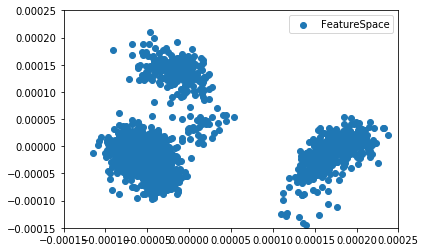

In [112]:
plt.scatter(electrode1_decomposed_spike_values[:,0],electrode1_decomposed_spike_values[:,1],label='FeatureSpace')
plt.axis((-0.00015, 0.00025, -0.00015, 0.00025)) 
#plt.axis (( beginning of y , end of y , beginning of x , end of x))
plt.legend(loc='best')

[[-5.57951342e-05 -1.69924561e-05]
 [ 1.71874652e-04 -1.15116635e-05]
 [-1.43236905e-05  1.34531234e-04]]
[0 0 1 ... 1 1 0]


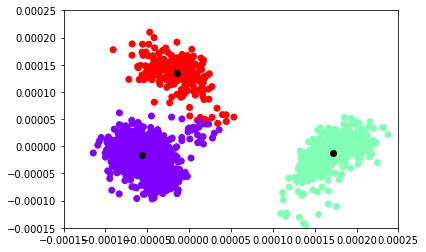

In [113]:
kmeans = KMeans(n_clusters=3)  
kmeans.fit(electrode1_decomposed_spike_values)  

plt.scatter(electrode1_decomposed_spike_values[:,0],electrode1_decomposed_spike_values[:,1], c=kmeans.labels_, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black') 
plt.axis((-0.00015, 0.00025, -0.00015, 0.00025)) 
print(kmeans.cluster_centers_) 
print(kmeans.labels_)

[1794, 4181, 4758, 5309, 5586, 6164, 6637, 8183, 8710, 9245, 10469, 11366, 14095, 15655, 16771, 17690, 18700, 19757]


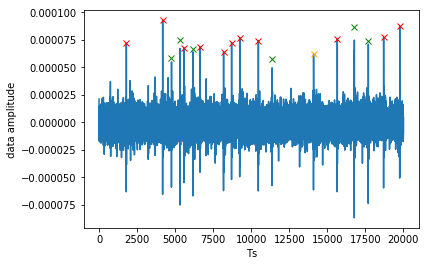

In [120]:
index=len(electrode1_timestamps[0:18])  #plotiing all smoothed data with colored spikes related to each neuron (red and green )
print(electrode1_timestamps[0:18])
x=np.arange(0,len(electrode1[0:20000]))
plt.xlabel('Ts')
plt.ylabel(' data amplitude ')
plt.plot(x,electrode1[0:20000]) #[0:20000]

for i in range(index):
    if(kmeans.labels_[i]==0):plt.plot(electrode1_timestamps[i],peak_values_elec1[i],'x',color='red')
    elif(kmeans.labels_[i]==1): plt.plot(electrode1_timestamps[i],peak_values_elec1[i],'x',color='green')
    elif(kmeans.labels_[i]==2): plt.plot(electrode1_timestamps[i],peak_values_elec1[i],'x',color='orange')
    elif(kmeans.labels_[i]==3): plt.plot(electrode1_timestamps[i],peak_values_elec1[i],'x',color='black')

#plt.plot(electrode1_timestamps[0:index],peak_values_elec1[0:index],'x',color=spikes_color)
plt.show()


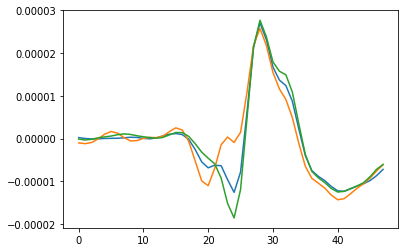

In [62]:
def template(electrode_timestamps,electrode_spike_values,k):
    index=len(electrode_timestamps)
    neuron1=np.zeros(48)
    neuron2=np.zeros(48)
    neuron3=np.zeros(48)
    neuron4=np.zeros(48)
    sum1=0
    sum2=0
    sum3=0
    sum4=0
    for i in range(index):
        if(kmeans.labels_[i]==0):
            neuron1=np.add(neuron1,electrode_spike_values[i])
            sum1+=1
        elif(kmeans.labels_[i]==1):
            neuron2=np.add(neuron2,electrode_spike_values[i])
            sum2+=1
        elif(kmeans.labels_[i]==2):
            neuron3=np.add(neuron3,electrode_spike_values[i])
            sum3+=1
        elif(kmeans.labels_[i]==3):
            neuron4=np.add(neuron4,electrode_spike_values[i])
            sum4+=1    
    if(k==2):
        neuron1=np.divide(neuron1,sum1)
        neuron2=np.divide(neuron2,sum2)
        return neuron1,neuron2
    elif(k==3):
        neuron1=np.divide(neuron1,sum1)
        neuron2=np.divide(neuron2,sum2)
        neuron3=np.divide(neuron3,sum3)
        return neuron1,neuron2,neuron3
    elif(k==4):
        neuron1=np.divide(neuron1,sum1)
        neuron2=np.divide(neuron2,sum2)
        neuron3=np.divide(neuron3,sum3)
        neuron4=np.divide(neuron4,sum4)
        return neuron1,neuron2,neuron3,neuron4
    
neuron1,neuron2,neuron3=template(electrode2_timestamps,electrode2_spike_values,3) 
plt.plot(neuron1)
plt.plot(neuron2)
plt.plot(neuron3)
#plt.plot(neuron4)
plt.show()

Please wait for plotting all peaks alligned...


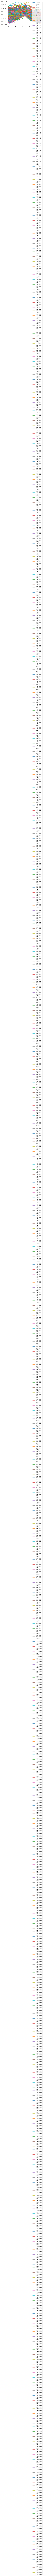

In [98]:
print("Please wait for plotting all peaks alligned...")
fullWave=electrode1_spike_values
r = fullWave.shape[0]
for k in range(r):
    x, = plt.plot([i for i in range(48)],[fullWave[k,i] for i in range(fullWave.shape[1])],label=' (%d) plot' %(k+1))
plt.legend()
plt.show()